# Multivariate GARCH with Skew-t Distributed Innovations

### Motivation

Many people assume that the simplicity and tractability of the Gaussian distribution make it the natural choice for modeling the distributions of returns. In fact, most practitioners are well aware that the assumption of lognormally distributed returns are not realistic, but use them anyway. This leads to many issues down the line, but perhaps most importantly, bad estimates of confidence intervals and, in the multivariate context, estimates of conditional correlations.

Luckily, there are well-studied multivariate distributions that capture the empirical skewness and kurtosis of financial time series much more accurately. The multivariate skew-t distribution proposed by Azzalini is a good choice for many such applications.

### Azzalini and Capitanios's Parameterization of the Multivariate Skew-t Distribution

We reference the work of [Azzalini and Capitanio (2003)]((https://arxiv.org/pdf/0911.2342)) in the following implementation of the multivariate skew-t distribution.

The multivariate skew-t distribution introduced by Azzalini and Capitanio extends the traditional Student's t-distribution to incorporate skewness, providing greater flexibility to model the asymmetry often observed in financial time series. Their parameterization is defined by a location vector $ \mu $, a scale matrix $ \Sigma $, a skewness parameter $ \lambda $, and degrees of freedom $ \nu $.

The probability density function (PDF) of the multivariate skew-t distribution can be expressed as:

$$
f(\mathbf{y}; \mu, \Sigma, \lambda, \nu) = 2 \, t_\nu(\mathbf{y}; \mu, \Sigma) \, T_{\nu + 1} \left( \lambda^\top \Sigma^{-1/2} (\mathbf{y} - \mu) \sqrt{\frac{\nu + d}{\nu + Q(\mathbf{y})}} \right),
$$

where:
- $ \mathbf{y} $ is the random vector.
- $ \mu $ is the location vector.
- $ \Sigma $ is the scale matrix (generalization of the covariance matrix).
- $ \lambda $ is the skewness parameter, controlling the asymmetry. It is important to note that it is *not* directly analogous to the statistical skewness or the third moment of the distribution.
- $ \nu $ represents the degrees of freedom, controlling the kurtosis.
- $ t_\nu(\mathbf{y}; \mu, \Sigma) $ is the PDF of the multivariate Student's t-distribution.
- $ T_{\nu + 1} $ is the cumulative distribution function (CDF) of the univariate t-distribution with $ \nu + 1 $ degrees of freedom.
- $ Q(\mathbf{y}) = (\mathbf{y} - \mu)^\top \Sigma^{-1} (\mathbf{y} - \mu) $ is the Mahalanobis distance.

This formulation allows for both heavy tails (through $ \nu $) and skewness (through $ \lambda $), making it particularly well-suited for modeling financial return distributions, where a multivariate Gaussian cannot capture the empirical features of the data.

### Multivariate GARCH with Skew-t Innovations

Integrating the multivariate skew-t distribution with a Generalized Autoregressive Conditional Heteroskedasticity (GARCH) framework enables the modeling of time-varying volatility and correlations while accounting for the empirical features of skewness and heavy tails in financial returns.

In this framework:
1. **Conditional Mean:** The mean process is often modeled as a VAR or VECM to capture dependencies among variables.  In this notebook, we will assume zero conditional mean at all time steps, since such mean modeling is out-of-scope of this demonstration.
2. **Conditional Scale Matrix:** A multivariate GARCH model, such as BEKK or DCC, is used to model the evolution of the variance-covariance matrix over time when using Gaussian innovations.  In the case of the multivariate skew-t distribution, the scale matrix, which generalizes the variance-covariance matrix to account for skewness in the distribution, evolves dynamically following a GARCH process.
3. **Skew-t Innovations:** The residuals (standardized returns) are assumed to follow a multivariate skew-t distribution.

This approach improves the robustness of the model in capturing key characteristics of financial data, including:
- **Asymmetry in Returns:** Captured through the skewness parameter $ \lambda $.
- **Heavy Tails:** Captured through the degrees of freedom parameter $ \nu $.
- **Dynamic Correlations:** Modeled through the time-varying structure of the GARCH process.

### Practical Considerations

- **Parameter Estimation:** Estimation of the model parameters typically involves maximum likelihood estimation (MLE) or Bayesian methods. These approaches can be computationally intensive due to the complexity of the multivariate skew-t likelihood function.
- **Software and Implementation:** Libraries such as `rmgarch` in R or custom Python implementations using `scipy` and `numpy` can facilitate the implementation of multivariate GARCH models with skew-t innovations.
- **Applications:** This framework is useful in portfolio optimization, option pricing, and systemic risk modeling, where accurate estimation of tail risk and correlations is critical.

In the next section, we will outline the steps to implement a Multivariate GARCH model with skew-t distributed innovations using just-in-time compiled (JIT) Python, leveraging `numpy` and `numba`.


# Implementation of the Azzalini and Capitanio Multivariate Skew-t Distribution

### Package Requirements
We will be heavily using `numpy` and `numba` throughout this workbook and shunning `scipy.stats`.  This is because of the need for JIT compilation to make the computationally intensive fitting and forecasting algorithms less time expensive.  Although not a 'requirement' in the traditional sense, it bears mentioning that we will be using the builtin `math.gamma` function for substantially the same reason.

We still use `scipy.optimize.minimize` to minimize the negative log-likelihood of the parameterization, and use `tqdm` to track it via a simple callback because we prefer its appearance to the verbose display output of `minimize`.

We use a `dataclass` to encapsulate the functionality of the GARCH model and bind the jitted functions to its data by calling them in its methods.

We use `joblib` to save and load the fitted model.

In [12]:
import dataclasses
import numba as nb
import numpy as np
from math import pi, gamma, lgamma
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import joblib

### Starting Point: Univariate Student's t PDF and CDF

We begin our study by implementing Student's t PDF and CDF using `numba` JIT compilation.  We do this because of the difficulty in using `scipy.stats` distribution functions directly with `numba`'s JIT. We make use of the `numba.prange` functionality and `numba.njit(parallel=True)` to parallelize the compiled code to run on multiple hardware threads, which greatly increases the efficiency of having a fine-grained numerical integration of the CDF.

In [13]:
@nb.njit(fastmath=True)
def t_pdf(x, nu):
    """
    Probability density function of the univariate t-distribution.
    """
    coef = gamma((nu + 1) / 2.0) / (np.sqrt(nu * pi) * gamma(nu / 2.0))
    return coef * (1.0 + (x**2) / nu) ** (-(nu + 1) / 2.0)

@nb.njit(fastmath=True, parallel=True)
def t_cdf(x, nu, n_points=1000):
    """
    CDF of the univariate t-distribution using numerical integration (trapezoidal rule).
    """
    # Exploit symmetry for x < 0
    if x < 0:
        return 1.0 - t_cdf(-x, nu, n_points)

    # Integration bounds
    a, b = -10.0, x
    if x > 10.0:
        b = x

    dx = (b - a) / n_points
    cdf_val = 0.0
    for i in nb.prange(n_points):
        t1 = a + i * dx
        t2 = a + (i + 1) * dx
        cdf_val += (t_pdf(t1, nu) + t_pdf(t2, nu)) * 0.5 * dx

    return cdf_val

### Azzalini and Capitanio PDF Implementation

We now implement the multivariate skew-t PDF following the parameterization detailed above. 

The form of the PDF is as follows:

$$
f(\mathbf{y}; \mu, \Sigma, \lambda, \nu) = \frac{\Gamma\left(\frac{\nu + d}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) (\nu \pi)^{d/2} |\Sigma|^{1/2}} \left(1 + \frac{Q(\mathbf{y})}{\nu}\right)^{-\frac{\nu + d}{2}} \cdot 2 \cdot T_{\nu + d}\left(\frac{\lambda^T \Sigma^{-1/2} (\mathbf{y} - \mu)}{\sqrt{1 + \frac{Q(\mathbf{y})}{\nu}}}\right),
$$

where:
- $\Sigma$ is the scale matrix.
- $Q(\mathbf{y}) = (\mathbf{y} - \mu)^T \Sigma^{-1} (\mathbf{y} - \mu)$ is the **Mahalanobis distance**, computed as `mahalanobis_dist = diff.T @ inv_scale @ diff`.
- $|\Sigma|$ is the **determinant of the scale matrix**, computed as `det_scale = np.linalg.det(scale)`.
- $\frac{\Gamma\left(\frac{\nu + d}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) (\nu \pi)^{d/2} |\Sigma|^{1/2}}$ is the **normalizing constant**, computed as `norm_const`
- $T_{\nu + d}\left(\frac{\lambda^T \Sigma^{-1/2} (\mathbf{y} - \mu)}{\sqrt{1 + \frac{Q(\mathbf{y})}{\nu}}}\right)$ is the **skew correction term**, where:
  - $\lambda$ corresponds to `skew`.
  - $\Sigma^{-1}$ corresponds to `inv_scale = np.linalg.inv(scale)`.
  - $\mathbf{y} - \mu$ corresponds to `diff = x - mean`.
  - The argument of $T_{\nu + d}$, or $w$, is computed as `w = (skew @ inv_scale @ diff) / np.sqrt(1.0 + mahalanobis_dist / df)`

The function `pdf` evaluates the skew-t PDF at a single point, while `pdf_batch` handles batch evaluation over multiple points.


In [14]:
@nb.njit(fastmath=True)
def pdf(x, mean, scale, df, skew):
    """
    PDF of the Azzalini skew-t at a single point x (d,).
    """
    dim = mean.shape[0]
    inv_scale = np.linalg.inv(scale)
    det_scale = np.linalg.det(scale)

    diff = x - mean
    # Mahalanobis distance or Q
    mahalanobis_dist = diff.T @ inv_scale @ diff

    # Multivariate t normalizing constant
    norm_const = (
        gamma((df + dim) / 2.0)
        / (
            gamma(df / 2.0)
            * (df * pi) ** (dim / 2.0)
            * np.sqrt(det_scale)
        )
    )
    t_val = norm_const * (1.0 + mahalanobis_dist / df) ** (-(df + dim) / 2.0)

    # Skew correction: 2 * T( w; df+dim )
    w = (skew @ inv_scale @ diff) / np.sqrt(1.0 + mahalanobis_dist / df)
    cdf_val = t_cdf(w, df + dim)
    return 2.0 * t_val * cdf_val

@nb.njit(parallel=True, fastmath=True)
def pdf_batch(x, mean, scale, df, skew):
    """
    PDF of the Azzalini skew-t at multiple points x (n, d).
    """
    ndim = mean.shape[0]

    flat_x = x.reshape(-1, ndim)
    result = np.empty(flat_x.shape[0])
    for i in nb.prange(flat_x.shape[0]):
        result[i] = pdf(flat_x[i], mean, scale, df, skew)
    return result.reshape(x.shape[:-1])

### Logpdf Implementation

We also implement the logpdf directly for use in optimization for stability purposes.

In [15]:
@nb.njit(fastmath=True)
def logpdf(x, mean, scale, df, skew):
    """
    Optimized Log of the Azzalini skew-t PDF at a single point x (d,).
    """
    dim = mean.shape[0]
    # Cholesky decomposition for inverse and determinant
    L = np.linalg.cholesky(scale)
    det_scale = np.prod(np.diag(L))**2
    inv_scale = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(L.shape[0])))

    diff = x - mean
    mahalanobis_dist = diff.T @ inv_scale @ diff

    # Log of the standard multivariate t portion
    log_norm_const = (
        lgamma((df + dim) / 2.0)
        - lgamma(df / 2.0)
        - (dim / 2.0) * np.log(df * np.pi)
        - 0.5 * np.log(det_scale)
    )
    log_t = log_norm_const - 0.5 * (df + dim) * np.log(1.0 + mahalanobis_dist / df)

    # Skew part
    sqrt_term = np.sqrt(1.0 + mahalanobis_dist / df)
    w = (skew @ inv_scale @ diff) / sqrt_term
    cdf_val = t_cdf(w, df + dim)  # Assuming t_cdf is pre-defined
    cdf_val = np.maximum(cdf_val, 1e-15)  # Stability adjustment
    log_cdf_term = np.log(cdf_val)

    # Final log-pdf
    return np.log(2.0) + log_t + log_cdf_term


@nb.njit(fastmath=True)
def logpdf_batch(x, mean, scale, df, skew):
    """
    Log of the Azzalini skew-t PDF at multiple points x (n, d).
    """
    ndim = mean.shape[0]

    flat_x = x.reshape(-1, ndim)
    result = np.empty(flat_x.shape[0])
    for i in range(flat_x.shape[0]):
        result[i] = logpdf(flat_x[i], mean, scale[i], df, skew)
    return result.reshape(x.shape[:-1])

In [16]:
@nb.njit(fastmath=True)
def logpdf(x, mean, scale, df, skew):
    """
    Log of the Azzalini skew-t PDF at a single point x (d,).

    log f_ST(x) = log(2) + log( f_{t_d}(x) ) + log( T_1(w; df + d) ),
    where w = alpha^T Sigma^{-1} (x - mean) / sqrt(1 + mahalanobis_dist/df).
    """
    dim = mean.shape[0]
    inv_scale = np.linalg.inv(scale)
    det_scale = np.linalg.det(scale)

    diff = x - mean
    mahalanobis_dist = diff.T @ inv_scale @ diff

    # log of the standard multivariate t portion
    #   log f_{t_d}(x) = log(norm_const) - (df + d)/2 * log(1 + mahalanobis_dist/df)
    #
    # norm_const = Gamma((df + d)/2) / [ Gamma(df/2) (df pi)^(d/2) sqrt(det_scale) ]
    # => log(norm_const) = logGamma((df+d)/2) - logGamma(df/2)
    #                     - (d/2)*log(df pi) - 0.5*log(det_scale)

    log_norm_const = (
        np.log(gamma((df + dim) / 2.0))
        - np.log(gamma(df / 2.0))
        - (dim / 2.0) * np.log(df * pi)
        - 0.5 * np.log(det_scale)
    )

    log_t = log_norm_const - 0.5 * (df + dim) * np.log(1.0 + mahalanobis_dist / df)

    # Skew part
    w = (skew @ inv_scale @ diff) / np.sqrt(1.0 + mahalanobis_dist / df)
    cdf_val = t_cdf(w, df + dim)
    # For stability, clamp cdf_val away from 0
    if cdf_val < 1e-15:
        cdf_val = 1e-15

    log_cdf_term = np.log(cdf_val)

    # final logpdf = log(2) + log_t + log_cdf_term
    return np.log(2.0) + log_t + log_cdf_term

@nb.njit(fastmath=True)
def logpdf_batch(x, mean, scale, df, skew):
    """
    Log of the Azzalini skew-t PDF at multiple points x (n, d).
    """
    ndim = mean.shape[0]

    flat_x = x.reshape(-1, ndim)
    result = np.empty(flat_x.shape[0])
    for i in range(flat_x.shape[0]):
        result[i] = logpdf(flat_x[i], mean, scale[i], df, skew)
    return result.reshape(x.shape[:-1])

### Sampling the Azzalini & Capitanio Multivariate Skew-t

The following code uses a latent dimension approach described by Azzalini and Capitanio to generate samples from the multivariate skew-t distribution. 

In this approach, we leverage the fact that a multivariate skew-t distribution can be constructed by augmenting the original random vector with an additional latent variable. Specifically:

1. **Latent Variable Augmentation**: A $(d+1)$-variate $t$ distribution is sampled, where:
   - The first $d$ dimensions correspond to the original variables (representing the target distribution).
   - The $(d+1)$-th dimension acts as a latent variable, introducing skewness into the distribution. 
   - The $(d+1)$-th variable is sampled independently, and its positivity is enforced to skew the distribution in the desired direction.

2. **Transformation to Skew-t**:
   - A random vector $\mathbf{Z} = (Z_1, Z_2, \ldots, Z_d, Z_{d+1})$ is sampled from a $(d+1)$-variate $t$ distribution with degrees of freedom $\nu$.
   - The first $d$ components of $\mathbf{Z}$ are conditionally transformed to form the skew-t random vector, conditional on $Z_{d+1} > 0$. This ensures that the resulting distribution is asymmetric.

3. **Acceptance-Rejection Mechanism**: 
   - Only samples where $Z_{d+1} > 0$ are retained. 
   - The skewness is introduced via the relationship between the latent variable $Z_{d+1}$ and the remaining $d$ dimensions.

4. **Key Benefits**:
   - This approach guarantees that the resulting samples adhere to the skew-t distribution properties.
   - It is computationally efficient when combined with parallel sampling.

The functions `rvs_multivariate_t` and `rvs` handle single-sample generation, while `rvs_batch` provides parallel sampling for multiple draws, utilizing `numba`'s parallelization capabilities for efficiency.

This method is particularly advantageous in high-dimensional settings, as the rejection step is straightforward and does not require recalculating parameters for each iteration.


In [17]:
@nb.njit(fastmath=True)
def rvs_multivariate_t(mean, scale, df):
    """
    Draw a single sample from a multivariate t distribution with mean, scale, df.
    """
    dim = mean.shape[0]
    # Chi-square for dof
    chi2_sample = np.random.chisquare(df)
    scale_factor = np.sqrt(df / chi2_sample)

    # Normal sample
    z = np.random.randn(dim)
    L = np.linalg.cholesky(scale)
    return mean + scale_factor * (L @ z)


@nb.njit(fastmath=True)
def rvs(mean, scale, df, skew, max_tries=10_000):
    """
    Random sample from the Azzalini skew-t (latent dimension approach).
    """
    dim = mean.shape[0]
    for _ in range(max_tries):
        # Build (d+1)-variate T with block covariance
        big_mean = np.zeros(dim + 1)
        big_cov = np.zeros((dim + 1, dim + 1))

        # top-left block
        big_cov[:dim, :dim] = scale
        # cross terms
        big_cov[:dim, dim] = scale @ skew
        big_cov[dim, :dim] = skew @ scale
        # bottom-right
        big_cov[dim, dim] = 1.0 + skew @ scale @ skew

        sample_all = rvs_multivariate_t(big_mean, big_cov, df)
        if sample_all[-1] > 0:
            return mean + sample_all[:dim]

    # If not accepted after max_tries
    return np.full(dim, np.nan)


@nb.njit(parallel=True, fastmath=True)
def rvs_batch(mu, forecast_H, df, skew, n_samples, test_size):
    """
    Generate random samples from the Azzalini skew-t distribution in parallel.
    """
    dim = mu.shape[0]
    res = np.zeros((n_samples, test_size, dim))
    
    for n in nb.prange(n_samples):
        for t in range(test_size):
            # Generate a single sample for the given forecast covariance
            res[n, t] = rvs(mu, forecast_H[t], df, skew)
    
    return res

### MGARCH-BEKK-GJR Implementation

We can now implement the jitted functions as well as a coordinating class for the GARCH process.  It is very similar to the previous Gaussian implementation posted to my feed and github, except that we now have to fit degrees of freedom $\nu$ and  skew parameter vector $\mathbf{\lambda}$ as well.  

In [18]:
@nb.njit
def _unpack_parms(params, p, q, ndim):
    """
    Unpack the parameter vector into the various coefficient matrices and vectors.
    """
    C_end = ndim ** 2
    C = params[:C_end].reshape((ndim, ndim))

    A_end = C_end + ndim * ndim * p
    A = params[C_end:A_end].reshape((p, ndim, ndim))

    B_end = A_end + ndim * ndim * q
    B = params[A_end:B_end].reshape((q, ndim, ndim))

    G_end = B_end + ndim * ndim * p
    G = params[B_end:G_end].reshape((p, ndim, ndim))

    skew = params[G_end:-1]
    df = params[-1]

    return C, A, B, G, df, skew


@nb.njit(fastmath=True)
def _forward(params, y, mu, p, q):
    """
    Compute the forward recursion for the MGARCH-BEKK-GJR model.
    """
    nobs, ndim = y.shape
    C, A, B, G, df, skew = _unpack_parms(params, p, q, ndim)
    H = np.zeros((nobs, ndim, ndim))
    H[0] = C @ C.T
    residuals = y - mu

    for t in range(1, nobs):
        H_t = C @ C.T

        for lag in range(1, min(p, t) + 1):
            epsilon = residuals[t - lag]
            I_neg = np.diag((epsilon < 0))
            H_t += (
                A[lag - 1].T @ np.outer(epsilon, epsilon) @ A[lag - 1]
                + G[lag - 1].T @ (np.outer(epsilon, epsilon) * I_neg) @ G[lag - 1]
            )

        for lag in range(1, min(q, t) + 1):
            H_t += B[lag - 1].T @ H[t - lag] @ B[lag - 1]

        H[t] = H_t + 1e-16 * np.eye(ndim)

    return H

@nb.njit(fastmath=True)
def _forecast(params, y, mu, p, q, steps, future_resids=None):
    """
    Forecast the next `steps` conditional scale matrices for MGARCH-BEKK-GJR.
    
    Parameters
    ----------
    params : 1d-array
        Model parameters (C, A, B, G, skew, df) all in one vector.
    y : 2d-array, shape (nobs, ndim)
        In-sample data.
    mu : 1d-array, shape (ndim,)
        Mean vector (often zeros).
    p, q : int
        Lag orders for the ARCH (A/G) and GARCH (B) parts.
    steps : int
        How many steps to forecast ahead.
    unconditional : bool
        If True, sets future residuals to zero. If False, you must supply `future_resids`.
    future_resids : 2d-array, shape (steps, ndim) or None
        If provided (and unconditional=False), these are the scenario or simulated
        future residuals used in the forecast recursion.
    
    Returns
    -------
    forecast_H : 3d-array, shape (steps, ndim, ndim)
        The forecasted covariance matrices for t = T+1 to T+steps.
    """
    # 1) Get in-sample H recursion up to time nobs
    H_in_sample = _forward(params, y, mu, p, q)
    nobs, ndim = y.shape

    # Unpack parameters
    C, A, B, G, df, skew = _unpack_parms(params, p, q, ndim)
    
    # 2) Build ring buffers for the last q covariances & last p residuals
    residuals = y - mu
    
    # H_buffer: store H_{T}, H_{T-1}, ... up to T-q+1  (most recent first or last)
    H_buffer = []
    # We'll store them with the most recent entry at index 0:
    for i in range(q):
        H_buffer.append(H_in_sample[nobs - 1 - i])  # H_{T-i}
    
    # resid_buffer: store e_{T}, e_{T-1}, ... up to T-p+1
    resid_buffer = []
    for i in range(p):
        resid_buffer.append(residuals[nobs - 1 - i])  # e_{T-i}
    
    # Convert to list-of-arrays for Numba
    H_buffer = list(H_buffer)        # length q
    resid_buffer = list(resid_buffer)  # length p
    
    # 3) Prepare output
    forecast_H = np.zeros((steps, ndim, ndim))
    
    # 4) For each step: compute H_{T+i}
    for i in range(steps):
        new_H = C @ C.T

        # Add p-lag terms with GJR
        for lag in range(p):
            # residual_buffer[lag] is e_{T-lag}, with T = current shift
            e = resid_buffer[lag]
            # negativity indicator
            I_neg = np.diag(e < 0)
            new_H += (A[lag].T @ np.outer(e, e) @ A[lag]
                      + G[lag].T @ (np.outer(e, e) * I_neg) @ G[lag])

        # Add q-lag terms
        for lag in range(q):
            H_lag = H_buffer[lag]
            new_H += B[lag].T @ H_lag @ B[lag]

        # This new_H is forecast for T + i + 1
        forecast_H[i] = new_H

        # Update ring buffers:
        # (a) Insert new_H at the front of H_buffer, pop the oldest
        H_buffer.insert(0, new_H)
        H_buffer.pop()

        # (b) For the residual buffer:
        if future_resids is None:
            # Future residual = 0 => no effect on next recursion
            new_resid = np.zeros(ndim)
        else:
            # scenario-based or simulated future residual
            new_resid = future_resids[i]
        
        resid_buffer.insert(0, new_resid)
        resid_buffer.pop()

    return forecast_H


@dataclasses.dataclass
class MGARCH_BEKK_GJR:
    """
    MGARCH-BEKK-GJR model with skew-t innovations.
    """
    C: np.ndarray
    A: np.ndarray
    B: np.ndarray
    G: np.ndarray
    mu: np.ndarray
    df: float
    skew: np.ndarray
    p: int
    q: int
    fit_y: np.ndarray

    def __post_init__(self):
        self.params = np.concatenate(
            (self.C.ravel(), self.A.ravel(), self.B.ravel(), self.G.ravel(), 
             self.skew.ravel(), np.array([self.df]))
        )
        self.fit_H = self.forward(self.fit_y)
        self.aic = (
            -2 * sum(
                logpdf_batch(
                    self.fit_y, self.mu, self.fit_H, self.df, self.skew
                )
            )
            + 2 * self.params.shape[0]
        )
        self.residuals = self.fit_y - self.mu

    @classmethod
    def from_params(cls, params, mu, p, q, fit_y):
        ndim = mu.shape[0]
        C, A, B, G, df, skew = _unpack_parms(params, p, q, ndim)
        return cls(C, A, B, G, mu, df, skew, p, q, fit_y)

    def forward(self, y):
        return _forward(self.params, y, self.mu, self.p, self.q)

    def __repr__(self):
        return (
            f"MGARCH_BEKK_GJR(C={self.C}, A={self.A}, B={self.B}, G={self.G}, "
            f"mu={self.mu}, p={self.p}, q={self.q})"
        )

    @staticmethod
    def initialize(n_dims, p=1, q=1):
        C_init = np.eye(n_dims) * 0.1
        A_init = [np.eye(n_dims) * 0.1 for _ in range(p)]
        B_init = [np.eye(n_dims) * 0.1 for _ in range(q)]
        G_init = [np.eye(n_dims) * 0.1 for _ in range(p)]
        df = 4.0
        skew = np.zeros(n_dims)
        parms = np.concatenate(
            [
                C_init.ravel(),
                *[a.ravel() for a in A_init],
                *[b.ravel() for b in B_init],
                *[g.ravel() for g in G_init],
                skew,
                np.array([df]),
            ]
        )
        return parms

    @classmethod
    def fit(cls, y, mu, p=1, q=1):
        initial_params = cls.initialize(y.shape[1], p, q)

        def objective(params):
            try:
                H = _forward(params, y, mu, p, q)
                skew_loc = params[-y.shape[1] - 1 : -1]
                df_loc = params[-1]
                return -np.sum(
                    logpdf_batch(y, mu, H, df_loc, skew_loc)
                )
            except:
                return np.inf

        pbar = tqdm(total=500)

        def callback(x):
            pbar.update(1)

        bounds = [(None, None)] * initial_params.shape[0]
        bounds[-1] = (2.1, None)

        result = minimize(
            objective,
            initial_params,
            options={"maxiter": 500},
            callback=callback,
        )
        return cls.from_params(result.x, mu, p, q, y)
    
    def forecast(self, steps, future_resids=None):
        """
        Forecast the next `steps` conditional covariance matrices for MGARCH-BEKK-GJR
        """
        return _forecast(self.params, self.fit_y, self.mu, self.p, self.q, steps, future_resids)
    
    def simulate(self, steps, paths):
        """
        Simulate `paths` scenarios of `steps` ahead from the model.
        """
        n_dims = self.mu.shape[0]
        forecasts = np.zeros((paths, steps, n_dims, n_dims))
        for i in range(paths):
            # Simulate future residuals from the skew-t
            future_resids = rvs(
                self.mu, self.fit_H[-1], self.df, self.skew, size=steps
            )
            forecasts[i] = self.forecast(steps, future_resids)
        return forecasts

### Example usage

We are now ready to begin fitting it to some data.  In this case, we will use roughly 14 years of daily log-returns data for 3 FX pairs: EURUSD, GBPUSD and USDJPY.  These correspond to Euros priced in US Dollars, British Pounds priced in US Dollars and US Dollars priced in Japanese Yen, respectively, for those who are not familiar with FX.

As a reminder, we are using constant zero means for all currency pairs, since mean modeling is out-of-scope of this demonstration, but in practice, for meaningful forecasting (as opposed to backtesting the goodness-of-fit on historical out-of-sample innovations), it is recommended to use a mean model.

In [19]:
import pandas as pd
from matplotlib import pyplot as plt
np.random.seed(777)

plt.style.use("dark_background")

data = pd.read_csv("data_fx.csv", index_col=0).dropna()
data.columns = ['EURUSD', 'GBPUSD', 'USDJPY']
log_returns = np.ascontiguousarray(np.log(data).diff().dropna().values)
test_size = int(0.2 * log_returns.shape[0])
train = log_returns[:-test_size]
test = log_returns[-test_size:]
print(f"Training size: {train.shape[0]}, Test size: {test_size}")

mu = np.zeros(log_returns.shape[1])

Training size: 3120, Test size: 779


### Note on fittin in the notebook format

Running this code in the notebook form is noticeably slower than as a module. It is recommended to run this in its own .py module if you care about time performance.  I have included the fitting loop over $p$ and $q$ based on minimum AIC for reference but load the already-fitted model via joblib. On an older T14s Ryzen laptop, the full loop took about two hours.  On newer hardware, and if you are just interested in fitting a (1, 1) model, which should be acceptably performant in most cases, it should take less time.

In [20]:
# from itertools import product

# best_model = None
# best_aic = np.inf
# for p, q in product(range(1, 3), range(1, 3)):
#     model = MGARCH_BEKK_GJR.fit(train, mu, p, q)
#     print(f'Model with p={p}, q={q} has AIC={model.aic}')
#     if model.aic < best_aic:
#         best_aic = model.aic
#         best_model = model

# print(f'Best model: {best_model}')
# joblib.dump(best_model, 'best_model_fx_t.garch')
best_model = joblib.load('best_model_fx_t.garch')

### 3d Residual Visualization

We visualize the residuals, annotating their empirical moments.  We can see that the time series do indeed exhibit excess kurtosis and significant negative skewness.

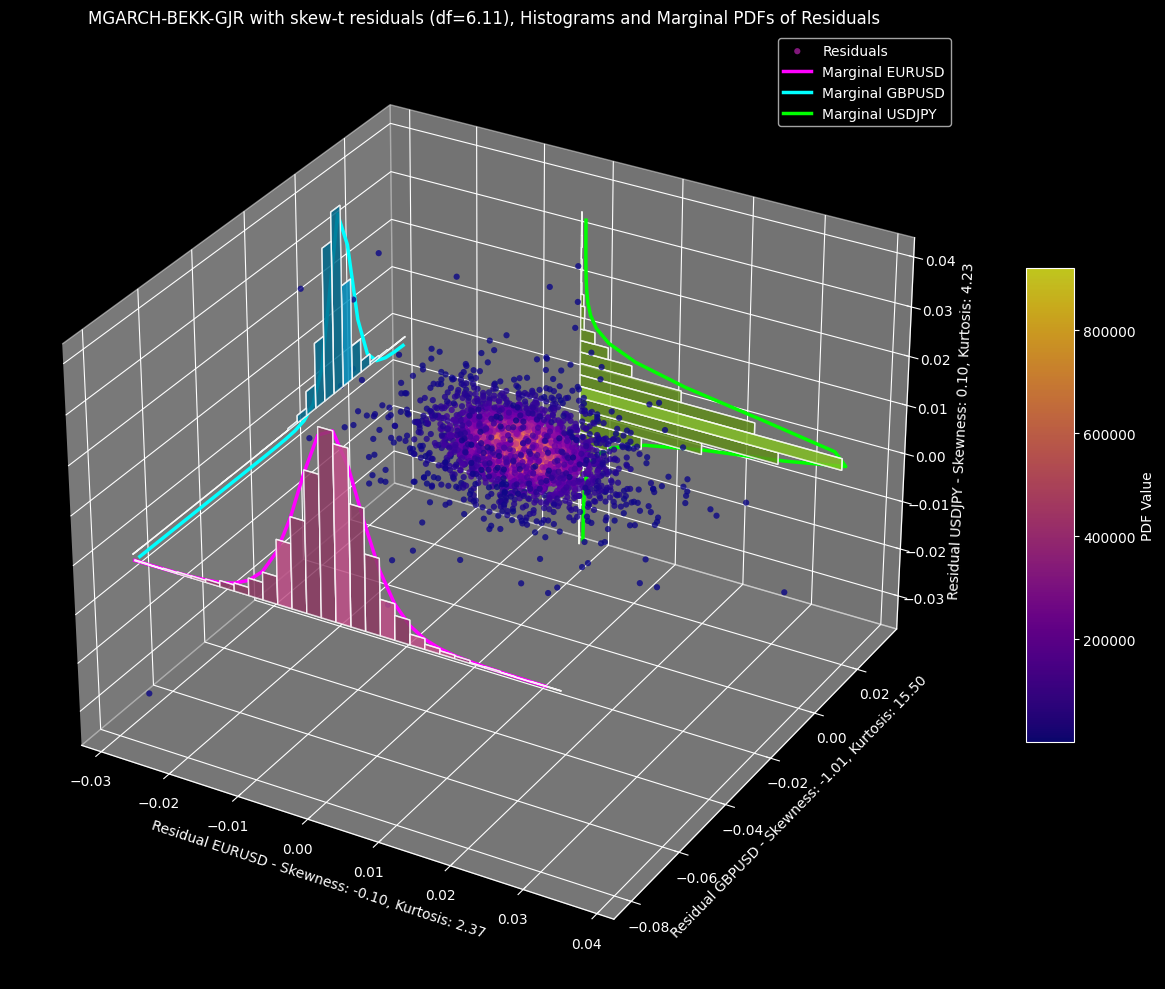

In [23]:
from models.plotting_util import plot_residuals_3d, plot_coverage_table, plot_forecasts_skewt, plot_correlations

plot_residuals_3d(best_model, data.columns)

### Residual Coverage Testing

We backtest the residual coverage using the actual historical out-of-sample residuals.  Although backtesting on roughly three years of out-of-sample data, we note that the coverage is very close to expectation.  None of the binomial coverage test p-values are significant at 5%.

**Note:** This is not a data leakage because at each timestep $t$, the conditional distribution is based off of the information we have at $t-1$. 

In [22]:
from models.stats_utils import binomial_coverage_test

Observed Coverage: [0.94865212 0.95378691 0.93581515]
Expected Coverage: 0.95
P-values: [0.86919765 0.68146896 0.07061159]


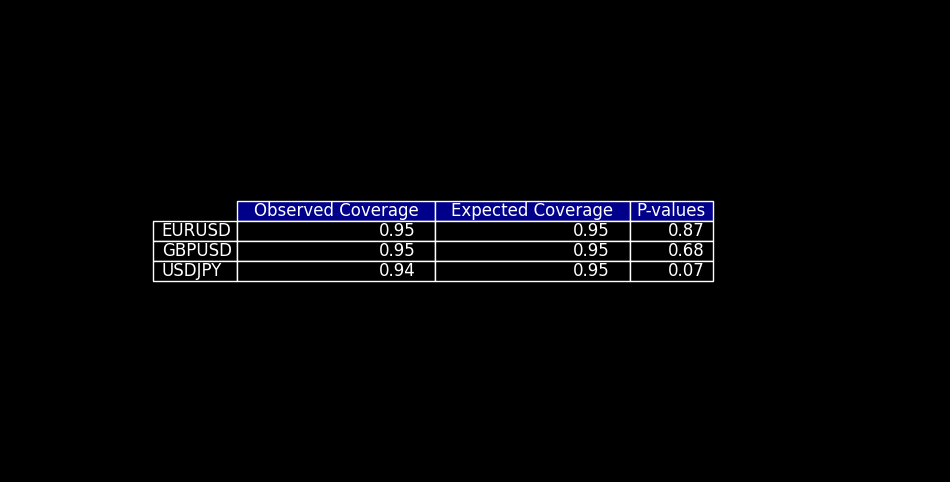

In [24]:

forecast = best_model.forward(test)

rvs = rvs_batch(
    best_model.mu, forecast, best_model.df, best_model.skew, 10_000, test_size
)

insample_H = best_model.forward(train)

insample_rvs = rvs_batch(
    best_model.mu, insample_H, best_model.df, best_model.skew, 10_000, train.shape[0]
)
insample_corrs = np.zeros((train.shape[0], 3, 3))
for t in range(train.shape[0]):
    frame = pd.DataFrame(insample_rvs[:, t])
    insample_corrs[t] = frame.corr()


skewness_forecasts = np.zeros((test_size, 3))
kurt_forecsts  = np.zeros((test_size, 3))
corr_forecasts = np.zeros((test_size, 3, 3))
std_forecasts = np.zeros((test_size, 3))
for t in range(test_size):
    frame = pd.DataFrame(rvs[:, t])
    std_forecasts[t] = frame.std()
    skewness_forecasts[t] = frame.skew()
    kurt_forecsts[t] = frame.kurt()
    corr_forecasts[t] = frame.corr()

# Preallocate arrays for quantiles
quantiles_lower = np.zeros((test_size, 3))
quantiles_upper = np.zeros((test_size, 3))

# Confidence interval (e.g., 95%)
alpha = 0.05
lower_percentile = 100 * (alpha / 2)  # e.g., 2.5%
upper_percentile = 100 * (1 - alpha / 2)  # e.g., 97.5%

# Compute quantiles for each timestep and dimension
for t in range(test_size):
    quantiles_lower[t] = np.percentile(rvs[:, t], lower_percentile, axis=0)
    quantiles_upper[t] = np.percentile(rvs[:, t], upper_percentile, axis=0)


# Example usage
results = binomial_coverage_test(test, quantiles_lower, quantiles_upper, alpha=0.05)
print("Observed Coverage:", results["observed_coverage"])
print("Expected Coverage:", results["expected_coverage"])
print("P-values:", results["p_values"])

coverage_table = pd.DataFrame(
    {
        "Observed Coverage": results["observed_coverage"],
        "Expected Coverage": results["expected_coverage"],
        "P-values": results["p_values"],
    },
    index=data.columns,
)


plot_coverage_table(coverage_table)


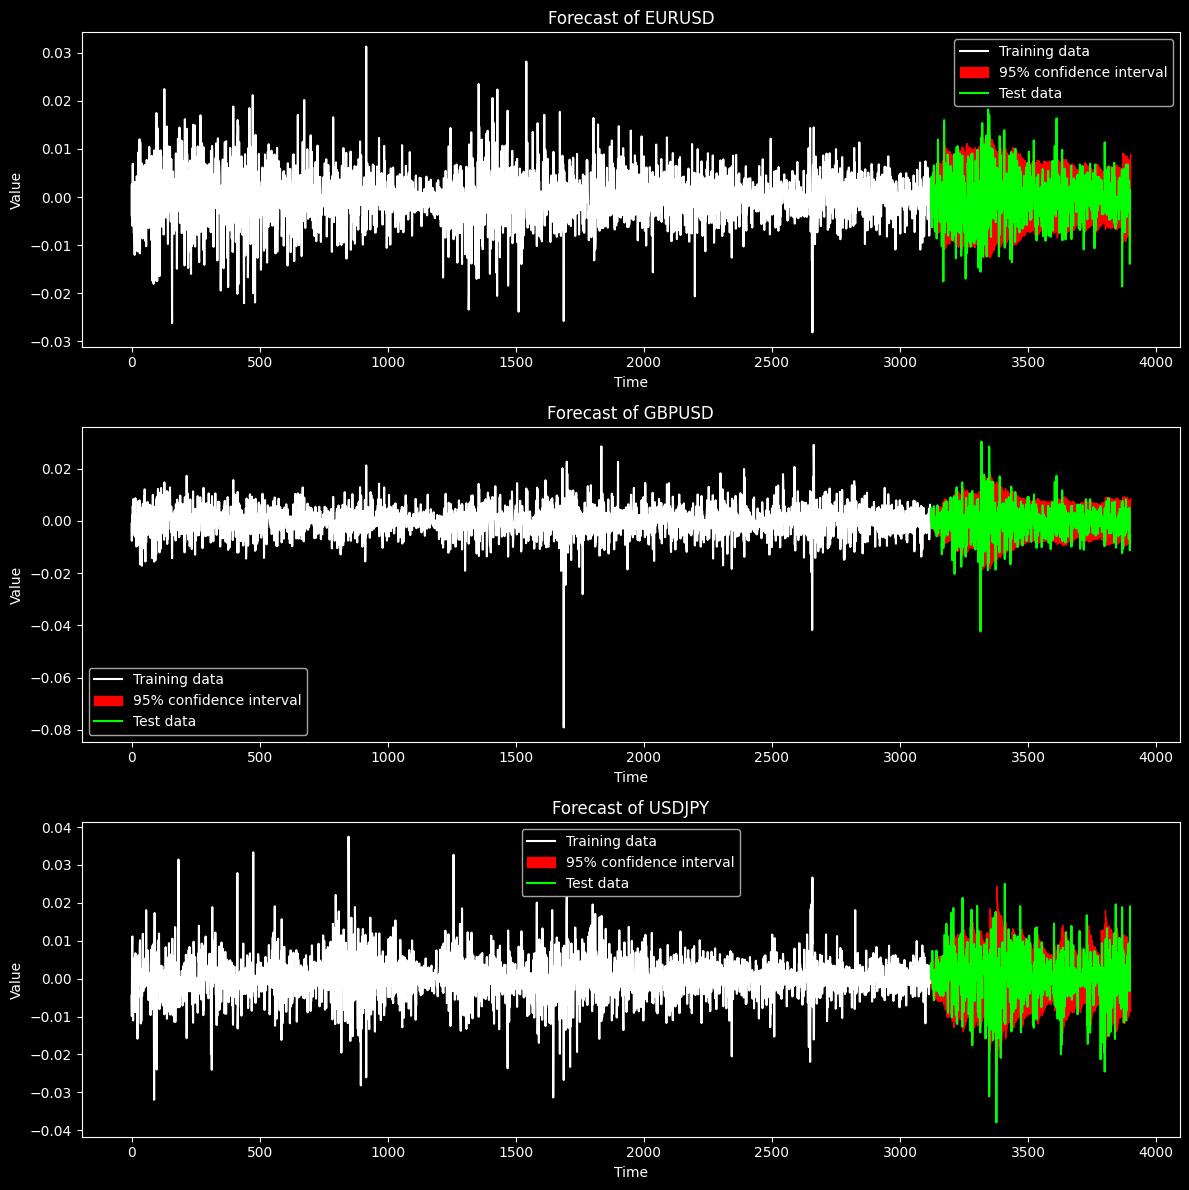

In [25]:
plot_forecasts_skewt(best_model, train, test, rvs, data.columns.tolist(), confidence=0.95)



### Conditional Correlations

Similar to the Gaussian model, we can derive the conditional correlation of the currency pairs using MC sampling.

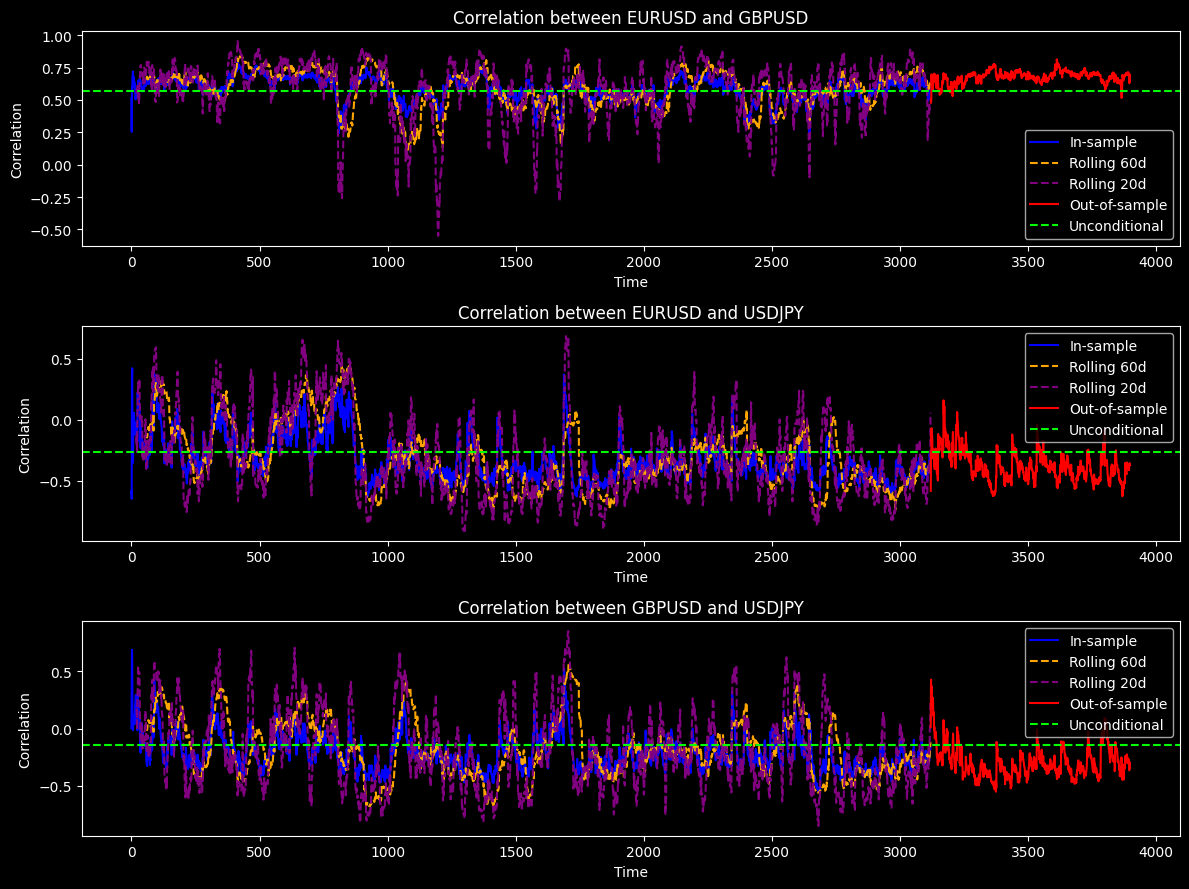

In [26]:
plot_correlations(best_model, insample_corrs, corr_forecasts, data.columns.tolist())